# Wine Quality Classification

## 1. Overview

### Multinomial Logistic Regression

<strong>Type</strong>: Classification </p>
<strong>UCI Open Source Dataset</strong>: [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality) </p>

This dataset contains red and white vinho verde wine samples, from the north of Portugal, and wine quality data based on physicochemical tests [Cortez et al., 2009](http://www3.dsi.uminho.pt/pcortez/wine/). 

<strong>Problem</strong>: Imagine you are a wine specialist who is looking for an automated way to categorize the wines you find based on wine quality data from physicochemical tests. You could use a machine learning algorithm to train a model that would be able to predict the quality of a wine based on its physicochemical properties. This would allow you to quickly and easily categorize new wines that you find, without having to manually taste them.

Here are some of the benefits of using an automated wine categorization system:

- <strong>Speed</strong>: An automated system can categorize wines much faster than a human can. This is especially beneficial for wine retailers and distributors who need to quickly categorize large numbers of wines.
- <strong>Accuracy</strong>: An automated system can be more accurate than a human when it comes to categorizing wines. This is because the system is not influenced by personal biases or preferences.
- <strong>Consistency</strong>: An automated system will consistently categorize wines in the same way, which can help to ensure that customers are getting the wines they expect.

If you are a wine specialist who is looking for an efficient and accurate way to categorize wines, then an automated system may be the perfect solution for you.

## 2. Setup

In [4]:
from google.cloud import storage, aiplatform, exceptions
from pyspark.sql import SparkSession

### Load dataset from public metastore

In [5]:
df = spark.read.table("public_datasets.winequality_white")

## 3. Exploratory Data Analysis

In [6]:
spark = SparkSession.builder \
    .appName("Multinomial logistic regression Wine Quality") \
    .enableHiveSupport() \
    .getOrCreate()

In [7]:
df.show(3)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
+-------------+----------------+-----------+--------------+---------+-------------------+-----------

### DataFrame Column Data Types

DataFrames may have heterogenous or "mixed" data types, that is, some columns are numbers, some are strings, and some are dates etc. Because CSV files do not contain information on what data types are contained in each column, Pandas infers the data types when loading the data, e.g. if a column contains only numbers, Pandas will set that column’s data type to numeric: integer or float.

Run the next cell to see information on the DataFrame.

In [8]:
df.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



### Summary Statistics 

At this point, we have all columns contains numerical values. For features which contain numerical values, we are often interested in various statistical measures relating to those values.

In [9]:
df.describe().show()

+-------+------------------+-------------------+-------------------+-----------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|     fixed_acidity|   volatile_acidity|        citric_acid|   residual_sugar|           chlorides|free_sulfur_dioxide|total_sulfur_dioxide|             density|                 pH|          sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+-----------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|              4898|               4898|               4898|             4898|                4898|               4898|                4898|                4898|               4898|               4898|              4898|              4898|
|   mean

Let's investigate a bit more of our target data by using the .groupby() function.

In [10]:
from pyspark.sql.functions import col, countDistinct, isnan, sum, when, count
import pyspark.sql.functions as F

In [11]:
df.groupby(
    col('quality')).\
    count().\
    show()

+-------+-----+
|quality|count|
+-------+-----+
|      6| 2198|
|      3|   20|
|      5| 1457|
|      9|    5|
|      4|  163|
|      8|  175|
|      7|  880|
+-------+-----+



We can see here that the data is <b>imbalanced</b> for our target. <b>Imbalanced</b> data is a common problem in machine learning, where the number of samples in one class is much larger than the number of samples in another class. This can make it difficult to train a model that can accurately predict the minority class. There are a number of techniques that can be used to handle imbalanced data, including:

- <b>Resampling</b>: This involves increasing the number of samples in the minority class or decreasing the number of samples in the majority class. This can be done by oversampling the minority class (creating new samples), undersampling the majority class (removing samples), or a combination of both.
- <b>Cost-sensitive learning</b>: This involves assigning different costs to misclassifications of different classes. This can help to focus the model on correctly classifying the minority class.
- <b>Ensemble learning</b>: This involves training multiple models on different subsets of the data and then combining the predictions of the models. This can help to improve the accuracy of the model on the minority class.

We need to <b>resample</b> the data to balance the dataset. However, before we do that, we need to check if there are any issues with the data that need to be resolved. For example, we need to make sure that there are no missing values in the data. We also need to make sure that the data is not corrupted. Once we have resolved any issues with the data, we can then resample it to balance the dataset.

### DataFrame Column Data Types

DataFrames may have heterogenous or "mixed" data types, that is, some columns are numbers, some are strings, and some are dates etc. Because CSV files do not contain information on what data types are contained in each column, Pandas infers the data types when loading the data, e.g. if a column contains only numbers, Pandas will set that column’s data type to numeric: integer or float.

Run the next cell to see information on the DataFrame.

In [12]:
df.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



### Summary Statistics 

At this point, we have all columns contains numerical values. For features which contain numerical values, we are often interested in various statistical measures relating to those values.

In [13]:
df.describe().show()

+-------+------------------+-------------------+-------------------+-----------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|     fixed_acidity|   volatile_acidity|        citric_acid|   residual_sugar|           chlorides|free_sulfur_dioxide|total_sulfur_dioxide|             density|                 pH|          sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+-----------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|              4898|               4898|               4898|             4898|                4898|               4898|                4898|                4898|               4898|               4898|              4898|              4898|
|   mean

Let's investigate a bit more of our target data by using the .groupby() function.

In [14]:
from pyspark.sql.functions import col, countDistinct, isnan, sum, when, count
import pyspark.sql.functions as F

In [15]:
df.groupby(
    col('quality')).\
    count().\
    show()

+-------+-----+
|quality|count|
+-------+-----+
|      6| 2198|
|      3|   20|
|      5| 1457|
|      9|    5|
|      4|  163|
|      8|  175|
|      7|  880|
+-------+-----+



We can see here that the data is <b>imbalanced</b> for our target. <b>Imbalanced</b> data is a common problem in machine learning, where the number of samples in one class is much larger than the number of samples in another class. This can make it difficult to train a model that can accurately predict the minority class. There are a number of techniques that can be used to handle imbalanced data, including:

- <b>Resampling</b>: This involves increasing the number of samples in the minority class or decreasing the number of samples in the majority class. This can be done by oversampling the minority class (creating new samples), undersampling the majority class (removing samples), or a combination of both.
- <b>Cost-sensitive learning</b>: This involves assigning different costs to misclassifications of different classes. This can help to focus the model on correctly classifying the minority class.
- <b>Ensemble learning</b>: This involves training multiple models on different subsets of the data and then combining the predictions of the models. This can help to improve the accuracy of the model on the minority class.

We need to <b>resample</b> the data to balance the dataset. However, before we do that, we need to check if there are any issues with the data that need to be resolved. For example, we need to make sure that there are no missing values in the data. We also need to make sure that the data is not corrupted. Once we have resolved any issues with the data, we can then resample it to balance the dataset.

### Let's summarize our data by row, column, features, unique, and missing values.

In [16]:
# In Python shape() is used in pandas to give the number of rows/columns.
# The number of rows is given by .shape[0]. The number of columns is given by .shape[1].
# Thus, shape() consists of an array having two arguments -- rows and columns

print ("Rows     : " ,df.count())
print ("Columns  : " ,len(df.columns))
print ("\nFeatures : \n" ,df.columns)
print ("\n Count Distinct values : ", "")
expression = [countDistinct(c).alias(c) for c in df.columns]
print ("\nUnique values :  \n", df.select(*expression).show())
print ("\nMissing values :  ", "")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Rows     :  4898
Columns  :  12

Features : 
 ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

 Count Distinct values :  
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|           68|             125|         87|           310|      160|                132|                 251|    890|103|       79|    103|      7|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------

There no missing values, or other data issue. So we can ressample the data.

### Distribution of Features

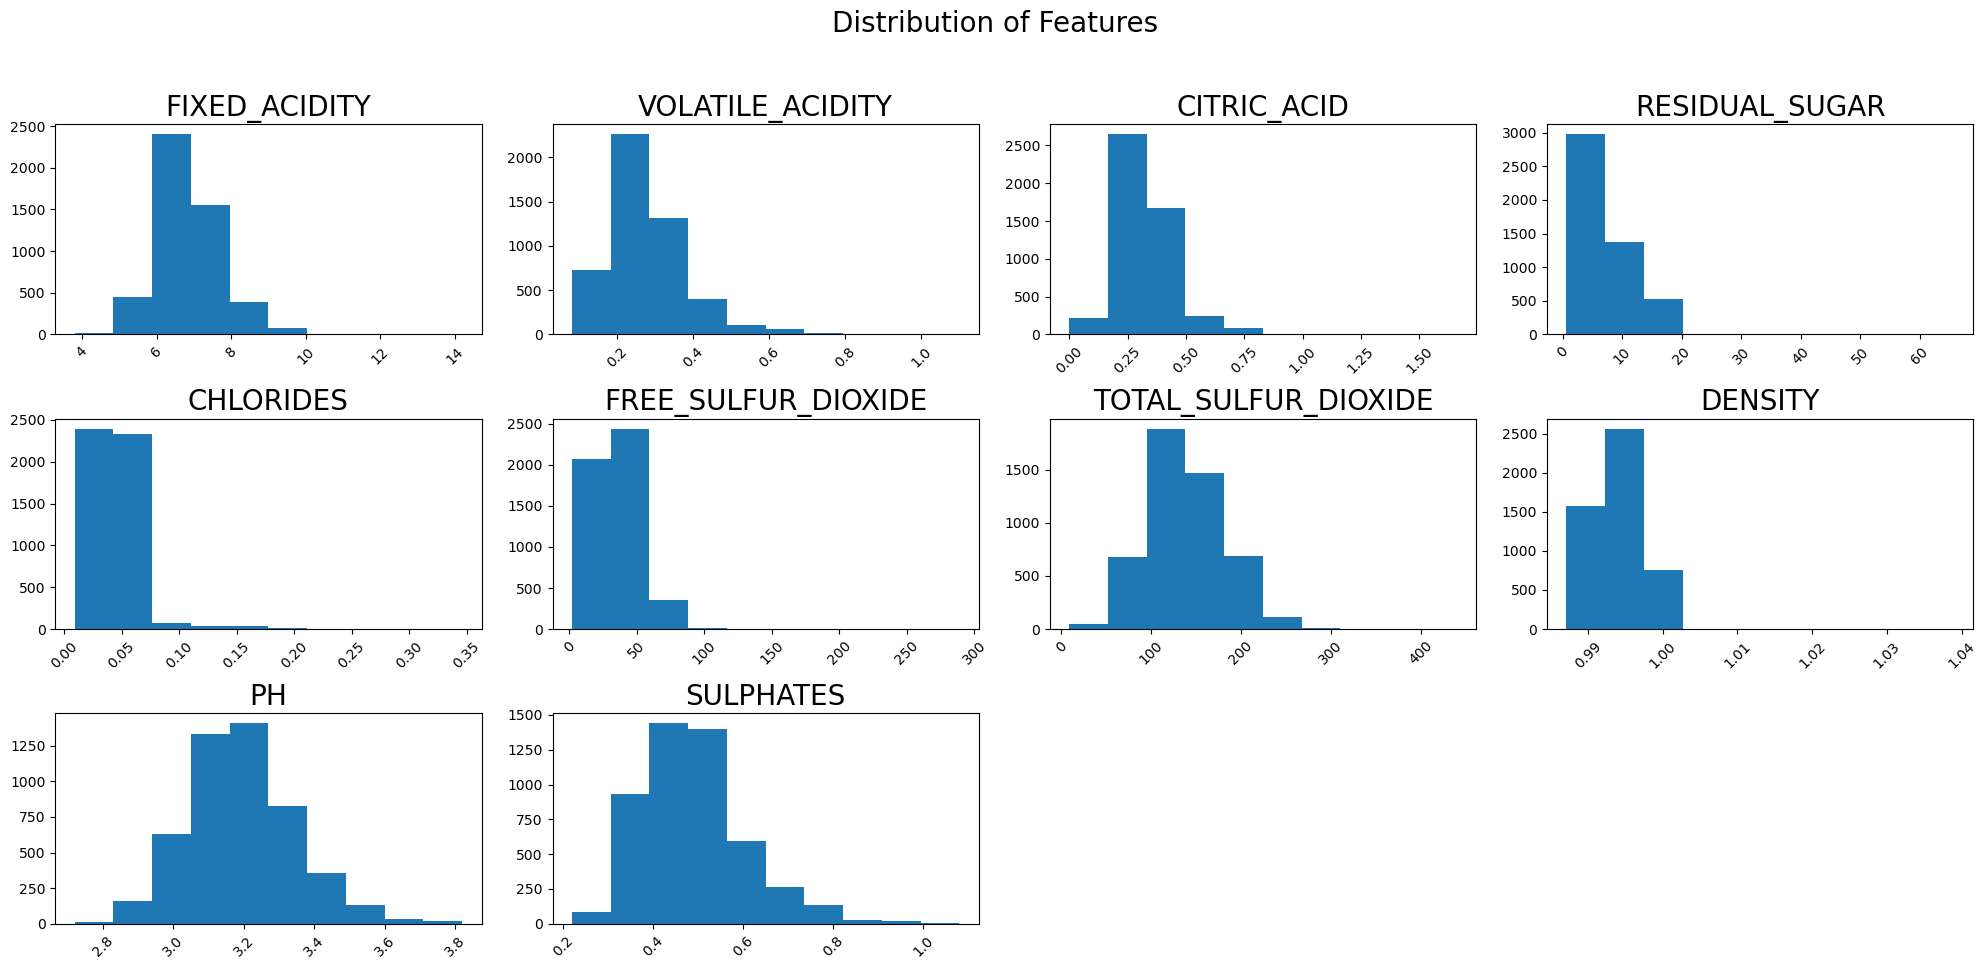

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(20,10))
st = fig.suptitle("Distribution of Features",
                  fontsize=20,
                  verticalalignment='center')

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

Great part of freatures had a normal distribution, also known as the Gaussian distribution, is a continuous probability distribution that is widely used in statistical modeling and machine learning. It is a bell-shaped curve that is symmetrical around its mean and is characterized by its mean and standard deviation.

In machine learning, data that is normally distributed is beneficial for model building because it makes the math easier. Many machine learning algorithms, such as linear regression and logistic regression, are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal. Additionally, sigmoid functions work most naturally with normally distributed data.

### Rename a Feature Column 

Our feature columns have different "capitalizations" in their names, e.g. both upper and lower "case".  In addition, there are "spaces" in some of the column names. 

In [18]:
df = df.withColumnRenamed("fixed acidity","fixed_acidity")\
.withColumnRenamed("volatile acidity","volatile_acidity")\
.withColumnRenamed("citric acid","citric_acid")\
.withColumnRenamed("residual sugar","residual_sugar")\
.withColumnRenamed("chlorides","chlorides")\
.withColumnRenamed("free sulfur dioxide","free_sulfur_dioxide")\
.withColumnRenamed("total sulfur dioxide","total_sulfur_dioxide")\
.withColumnRenamed("density","density")\
.withColumnRenamed("pH","pH")\
.withColumnRenamed("sulphates","sulphates")\
.withColumnRenamed("alcohol","alcohol")\
.withColumnRenamed("quality","quality")

In [19]:
df.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



### Pearson Correlation

In [20]:
from pyspark.mllib.stat import Statistics
import pandas as pd

col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat= Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile_acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric_acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual_sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free_sulfur_dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total_sulfur_dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


A Pearson correlation coefficient of 0.7 or greater is generally considered to be a strong correlation. This means that there is a high degree of linear relationship between the two variables. For example, if the correlation coefficient between height and weight is 0.7, this means that taller people tend to be heavier, on average.

However, it is important to note that the strength of a correlation coefficient can vary depending on the specific variables being measured. For example, a correlation coefficient of 0.7 might be considered strong for some variables, but weak for others.

Here we could see that residual_sugar have a <b>strong correlation</b> with <b>density</b>.

## 4. Feature engineering

<b>Feature engineering</b> is the process of transforming raw data into features that are more informative and useful for machine learning algorithms. This can involve a variety of tasks, such as:

- <b>Data transformation</b>: This involves transforming the data into a format that is more suitable for machine learning algorithms. For example, categorical data can be encoded as numerical data, and continuous data can be discretized.
- <b>Feature selection</b>: This involves selecting the most important features from the data set. This can be done using a variety of techniques, such as statistical significance tests and feature importance scores.
- <b>Feature creation</b>: This involves creating new features from the existing data. This can be done by combining existing features, or by creating derived features that are based on the relationships between different features.

### Bucketing a quality label

- Poor for less than 3
- Poor between 4 and 5 (inclusive)
- Good between 6 and 7
- Excelent for more than 7

In [21]:
from pyspark.sql.types import StringType
from pyspark.sql import functions as F

@F.udf(returnType=StringType())
def quality_score_to_label(score: int):
    if score >=0 and score < 4:
        return 'poor'
    elif score >=4 and score <=5:
        return 'normal'
    elif score >=6 and score <=7:
        return 'good'
    else: 
        return 'excelent'

In [22]:
df_buc = df.withColumn('quality_label', quality_score_to_label('quality'))
df_buc = df_buc.drop('quality')
df_buc.show(2)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality_label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001|3.0|     0.45|    8.8|         good|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994|3.3|     0.49|    9.5|         good|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------------+
only showing top 2 rows



### LabelIndexer

In [27]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer()\
            .setInputCol ("quality_label")\
            .setOutputCol ("quality")

label_indexer_model = label_indexer.fit(df_buc)
label_indexer_df = label_indexer_model.transform(df_buc)

label_indexer_df = label_indexer_df.drop('quality_label')

label_indexer_df.show(2)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001|3.0|     0.45|    8.8|    0.0|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994|3.3|     0.49|    9.5|    0.0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
only showing top 2 rows



In [28]:
label_indexer_df.groupby(
    F.col('quality')).\
    count().\
    show()

+-------+-----+
|quality|count|
+-------+-----+
|    0.0| 3078|
|    1.0| 1620|
|    3.0|   20|
|    2.0|  180|
+-------+-----+



### Resampling [Optional step]

In [29]:
from imblearn.over_sampling import SMOTE

X, y = label_indexer_df.toPandas().iloc[:, :-1], label_indexer_df.toPandas().iloc[:, [-1]]
sm = SMOTE(k_neighbors=6)
X_res, y_res = sm.fit_resample(X, y)

In [30]:
df_res = spark.createDataFrame(pd.concat([X_res, y_res], axis=1))
df_res.show(2)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001|3.0|     0.45|    8.8|    0.0|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994|3.3|     0.49|    9.5|    0.0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
only showing top 2 rows



In [31]:
from pyspark.sql import functions as F

In [32]:
df_res.groupby(
    F.col('quality')).\
    count().\
    show()

+-------+-----+
|quality|count|
+-------+-----+
|    0.0| 3078|
|    1.0| 3078|
|    3.0| 3078|
|    2.0| 3078|
+-------+-----+



### Vectoring to prepare Data for Machine Learning

In [36]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

df_vec= df_res.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["vectorized_features", "label"])
df_vec.show(2)

+--------------------+-----+
| vectorized_features|label|
+--------------------+-----+
|[7.0,0.27,0.36,20...|  0.0|
|[6.3,0.3,0.34,1.6...|  0.0|
+--------------------+-----+
only showing top 2 rows



### Standardization

In [37]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model = scaler.fit(df_vec)
scaler_df = scaler_model.transform(df_vec)

scaler_df = scaler_df.select('features', 'label')
scaler_df.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.99576901327996...|  0.0|
|[6.29619211195196...|  0.0|
+--------------------+-----+
only showing top 2 rows



## 5. Model Choice

<b>Multinomial logistic regression</b> is a type of logistic regression that can be used for multi-class classification problems. In the case of wine quality classification, there are 4 classes (poor, normal, good and excelent) so multinomial logistic regression is a good choice for modeling this problem.

The physicochemical tests can be used to measure the various properties of wine, such as acidity, alcohol content, and sugar content. These properties can then be used as features in the multinomial logistic regression model.

Here are some of the advantages of using multinomial logistic regression for wine quality classification:

- It is a relatively simple model that is easy to understand and interpret.
- It is a very flexible model that can be used to model a variety of different types of data.
- It is a very efficient model that can be estimated quickly and easily.

Here is some of the disadvantages of using multinomial logistic regression for wine quality classification:

- It may not be as accurate as some other models, such as support vector machines or decision trees.
- It may not be able to capture the nonlinear relationships between the features and the class labels.

In addition to multinomial logistic regression, there are a number of other models that could be used for wine quality classification. Some of these other models include support vector machines, decision trees, and random forests. However, multinomial logistic regression is a good starting point for wine quality classification because it is a simple, flexible, and efficient model.


## 6. Model Training

### Train/Test Split data  

In [38]:
# Split training and test data
training, test = scaler_df.randomSplit([0.8, 0.2])

print ("training instances", training.count(), "test instances", test.count())

training instances 9871 test instances 2441


### Model Training phase

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    family="multinomial", 
    featuresCol = 'features', 
    labelCol = 'label',
    maxIter=200,
    elasticNetParam=1.0, 
    tol=1e-6, 
    standardization=True,
    fitIntercept=True
)
    
# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

23/06/23 02:24:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/23 02:24:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: 
DenseMatrix([[-3.67529068e-01, -3.97786047e-01,  2.98822570e-02,
               4.52674234e-03, -7.21416896e-02, -6.33224097e-02,
              -2.18937549e-02,  2.15119306e-02, -2.94895020e-01,
               2.40152500e-01,  2.64378799e-01],
             [-2.48557233e-01,  4.68692525e-01,  1.16561513e-01,
              -3.42594465e-01, -1.39570801e-01, -3.77277221e-01,
               1.02892124e-01,  4.34166452e-02, -1.83707057e-01,
               4.92681955e-04, -1.18516662e+00],
             [-2.47462733e-01, -5.67664044e-01, -1.23392357e-01,
               4.21050259e-01, -1.25734635e-01,  2.26949197e-01,
              -1.04611473e-01, -1.54648676e-02, -1.62057760e-01,
               1.69525384e-01,  1.35036841e+00],
             [ 8.63549033e-01,  4.96757567e-01, -2.30514135e-02,
              -8.29825362e-02,  3.37447125e-01,  2.13650433e-01,
               2.36131036e-02, -4.94637083e-02,  6.40659837e-01,
              -4.10170566e-01, -4.29580586e-01]])
Intercep

## 7. Model Evaluation

In [40]:
predictions = lrModel.transform(test)

### Confusion Matrix

In [41]:
class_names=list([0,1,2,3])

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[188 140 176  88]
 [100 371  19 144]
 [113  37 372  93]
 [ 83 112  59 346]]


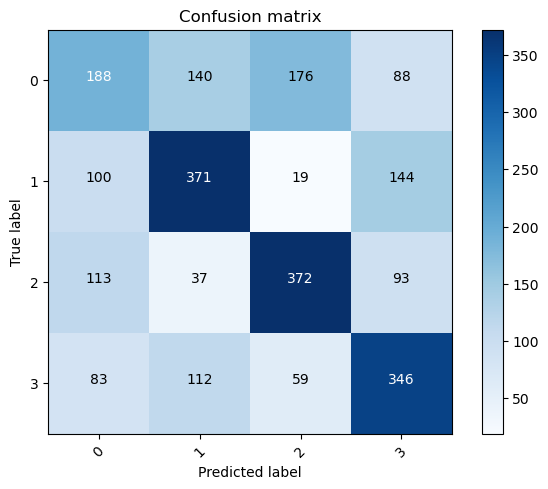

In [42]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(
    y_true,
    y_pred,
    labels=class_names
)

plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=class_names,
    title='Confusion matrix'
)

plt.show()

## 8. Prediction

In [43]:
predictions.select(
    'label',
    'features',
    'rawPrediction',
    'prediction',
    'probability'
).toPandas()\
.head(10)

,label,features,rawPrediction,prediction,probability
0,2.0,"[3.8976427359702646, 2.2072459957132007, 4.038...","[1.136368179600305, -1.7094405500987946, 2.351...",2.0,"[0.22309393640113775, 0.012958917906009598, 0...."
1,0.0,"[4.397340522633119, 4.5125918134581, 1.0095734...","[0.153029348104244, -1.1886073655247873, 1.615...",2.0,"[0.16508431600759846, 0.04315592137717419, 0.7..."
2,1.0,"[4.49728007996569, 1.8638966186022585, 2.12010...","[0.47187470762242195, 2.0450964825664157, -2.0...",1.0,"[0.1592701591376285, 0.7680260481051342, 0.013..."
3,0.0,"[4.6971591946308315, 4.463541902442251, 1.8172...","[1.8718777217708018, -1.725654123660205, 3.383...",2.0,"[0.1796805226608195, 0.004921673202002625, 0.8..."
4,0.0,"[4.797098751963402, 2.2072459957132007, 3.8363...","[0.7499169469545811, 0.49128630250164856, -0.5...",0.0,"[0.4378794237450414, 0.33809027302238953, 0.12..."
5,1.0,"[4.797098751963402, 3.237294127046028, 0.0, 1....","[0.6935071429146228, 0.9756459002914213, -0.23...",1.0,"[0.3520555470185227, 0.46681252167772636, 0.13..."
6,0.0,"[4.897038309295974, 2.3053458177448984, 2.7258...","[1.3612991408412936, 1.1954734626673809, 0.087...",0.0,"[0.46618896442631746, 0.3949524495696164, 0.13..."
7,1.0,"[4.897038309295974, 3.3844438600935742, 3.4325...","[0.3798592163724284, 1.5213361579775395, -1.41...",1.0,"[0.2119593965912317, 0.663727499166497, 0.0352..."
8,1.0,"[4.897038309295974, 3.3844438600935742, 3.4325...","[0.3798592163724284, 1.5213361579775395, -1.41...",1.0,"[0.2119593965912317, 0.663727499166497, 0.0352..."
9,0.0,"[4.996977866628544, 2.3543957287607475, 2.1201...","[0.7139711828439043, -1.2004760283371538, 1.16...",2.0,"[0.3377153267000169, 0.04978710928029406, 0.52..."
